# Exploratory Data Analysis of Toxic Comments

## Описание проекта
Цель данного анализа — исследование корпуса текстов комментариев с целью выявления паттернов в токсичных и нетоксичных сообщениях. 

**Основные задачи:**
1. Очистка и предобработка текстовых данных
2. Лемматизация и удаление стоп-слов
3. Анализ частотности слов (TF-IDF)
4. Сравнительный анализ токсичных vs нетоксичных комментариев
5. Визуализация распределений

**Данные:** Датасет содержит текстовые комментарии и бинарную метку токсичности (0 — положительный, 1 — отрицательный).

**Автор:** Илья Хакимов
**Дата:** 2024

## Оглавление
1. [Импорт библиотек](#import)
2. [Загрузка данных](#load)
3. [Предобработка текста](#preprocessing)
4. [Анализ TF-IDF](#tfidf)
5. [Анализ частотности слов](#frequency)
6. [Сравнительный анализ по классам](#comparison)
7. [Выводы](#conclusions)

<a id='import'></a>
## 1. Импорт библиотек

В данном разделе импортируются все необходимые библиотеки для анализа данных, обработки естественного языка (NLP) и визуализации.

In [9]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter

# Загрузка необходимых данных NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/piratethunder/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<a id='load'></a>
## 2. Загрузка данных

Загружаем датасет с комментариями. Данные содержат два столбца:
- `text` — текст комментария
- `toxic` — метка класса (0: положительный, 1: отрицательный)

In [10]:
# 1. Создание DataFrame с данными
df = pd.read_csv("./comments.csv")
print("Исходные данные:")
print(df)
print(f"\nРазмер датасета: {df.shape}")

Исходные данные:
                                                     text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159566  ":::::And for the second time of asking, when ...      0
159567  You should be ashamed of yourself \n\nThat is ...      0
159568  Spitzer \n\nUmm, theres no actual article for ...      0
159569  And it looks like it was actually you who put ...      0
159570  "\nAnd ... I really don't think you understand...      0

[159571 rows x 2 columns]

Размер датасета: (159571, 2)


<a id='preprocessing'></a>
## 3. Предобработка текста

Этап предобработки включает три ключевых шага:
1. **Очистка текста** — удаление специальных символов, приведение к нижнему регистру
2. **Лемматизация** — приведение слов к начальной форме
3. **Удаление стоп-слов** — исключение часто встречающихся слов без смысловой нагрузки

Эти шаги необходимы для улучшения качества последующего анализа и уменьшения размерности данных.

In [11]:
# 2. Функция для очистки текста (только слова)
def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление всего, кроме букв (оставляем только слова)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Применение очистки
df['cleaned_text'] = df['text'].apply(clean_text)
print("\nОчищенные тексты:")
print(df[['cleaned_text', 'toxic']].head())


Очищенные тексты:
                                        cleaned_text  toxic
0  explanation why the edits made under my userna...      0
1  daww he matches this background colour im seem...      0
2  hey man im really not trying to edit war its j...      0
3  more i cant make any real suggestions on impro...      0
4  you sir are my hero any chance you remember wh...      0


**Примечание:** Для лемматизации используем `WordNetLemmatizer` из NLTK. 
В качестве альтернативы можно использовать `PorterStemmer` для более быстрой, но менее точной обработки.

In [12]:
# 3. Лемматизация и удаление стоп-слов
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_and_remove_stopwords(text):
    # Токенизация
    tokens = word_tokenize(text)
    # Лемматизация и удаление стоп-слов
    processed_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 1
    ]
    return ' '.join(processed_tokens)

df['processed_text'] = df['cleaned_text'].apply(lemmatize_and_remove_stopwords)
print("\nОбработанные тексты (лемматизированные, без стоп-слов):")
print(df[['processed_text', 'toxic']].head())


Обработанные тексты (лемматизированные, без стоп-слов):
                                      processed_text  toxic
0  explanation edits made username hardcore metal...      0
1  daww match background colour im seemingly stuc...      0
2  hey man im really trying edit war guy constant...      0
3  cant make real suggestion improvement wondered...      0
4                sir hero chance remember page thats      0


<a id='tfidf'></a>
## 4. Анализ TF-IDF

**TF-IDF** (Term Frequency — Inverse Document Frequency) — статистическая мера, используемая для оценки важности слова в документе относительно всего корпуса.

**Почему TF-IDF важен:**
- Учитывает не только частоту слова, но и его специфичность для документа
- Помогает выявить ключевые термины, характерные для конкретных текстов
- Снижает вес общих слов, встречающихся во многих документах

**Важно:** При работе с большими корпусами избегаем конвертации разреженной матрицы в плотный массив (`toarray()`) для экономии памяти.

In [14]:
# 4. Вычисление TF-IDF для корпуса текстов (исправленная версия)
from scipy.sparse import csr_matrix
import pandas as pd

# Фильтруем пустые строки
corpus = df['processed_text'].tolist()
corpus = [text for text in corpus if text.strip()]

# Ограничиваем размер словаря для экономии памяти (опционально)
vectorizer = TfidfVectorizer(max_features=10000)  # Ограничиваем 10к самых частых слов
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

print(f"\nРазмерность TF-IDF матрицы: {tfidf_matrix.shape}")
print(f"Количество уникальных слов: {len(feature_names)}")
print(f"Тип матрицы: {type(tfidf_matrix)}")
print(f"Ненулевых элементов: {tfidf_matrix.nnz}")
print(f"Занимаемая память (MB): {tfidf_matrix.data.nbytes / 1024 / 1024:.2f}")

# НЕ конвертируем в toarray()! Работаем с разреженной матрицей
# Вместо DataFrame показываем только статистику и примеры

# Показываем TF-IDF для первых 5 документов (только ненулевые значения)
print("\nПримеры TF-IDF значений (первые 5 документов, топ-5 слов по TF-IDF в каждом):")

for doc_idx in range(min(5, len(corpus))):
    # Получаем строку документа как разреженную
    doc_row = tfidf_matrix[doc_idx]
    
    # Находим индексы ненулевых элементов и их значения
    indices = doc_row.indices
    data = doc_row.data
    
    # Сортируем по убыванию TF-IDF
    top_indices = indices[np.argsort(data)[-5:][::-1]]  # Топ-5
    top_values = np.sort(data)[-5:][::-1]
    
    print(f"\nДокумент {doc_idx}:")
    for idx, val in zip(top_indices, top_values):
        print(f"  {feature_names[idx]}: {val:.4f}")


Размерность TF-IDF матрицы: (159520, 10000)
Количество уникальных слов: 10000
Тип матрицы: <class 'scipy.sparse._csr.csr_matrix'>
Ненулевых элементов: 3813827
Занимаемая память (MB): 29.10

Примеры TF-IDF значений (первые 5 документов, топ-5 слов по TF-IDF в каждом):

Документ 0:
  closure: 0.3079
  hardcore: 0.3063
  retired: 0.2785
  gas: 0.2732
  fac: 0.2716

Документ 1:
  seemingly: 0.4258
  colour: 0.4147
  stuck: 0.3880
  background: 0.3490
  match: 0.3442

Документ 2:
  formatting: 0.3131
  constantly: 0.3043
  actual: 0.2466
  talking: 0.2376
  info: 0.2317

Документ 3:
  format: 0.3138
  later: 0.2613
  reference: 0.2076
  backlog: 0.2064
  wondered: 0.2045

Документ 4:
  hero: 0.5382
  sir: 0.4883
  chance: 0.4329
  remember: 0.3915
  thats: 0.3081


<a id='frequency'></a>
## 5. Анализ частотности слов

В данном разделе анализируем распределение слов по всему корпусу. 
Используем простую частотность (Counter) для выявления наиболее употребляемых терминов.

**Ожидаемые результаты:**
- Выявление доминирующих тем в корпусе
- Понимание лексического состава комментариев
- База для сравнительного анализа между классами


Топ-10 самых популярных слов по частоте:
article: 72961
page: 56491
wikipedia: 35601
talk: 31814
one: 29936
please: 29616
would: 29212
like: 28131
dont: 26102
see: 21695


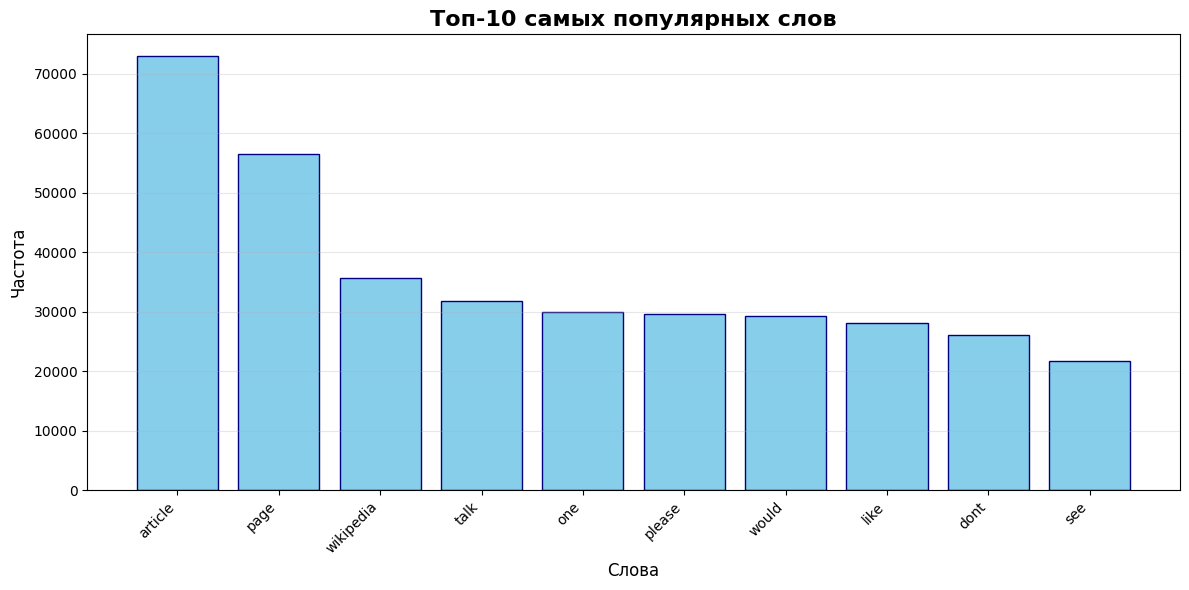

In [15]:
# 5. Топ-10 самых популярных слов (по частоте, не TF-IDF)
from collections import Counter

all_words = []
for text in df['processed_text']:
    all_words.extend(text.split())

word_freq = Counter(all_words)
top_10_words = word_freq.most_common(10)

print("\nТоп-10 самых популярных слов по частоте:")
words, counts = zip(*top_10_words)
for word, count in top_10_words:
    print(f"{word}: {count}")

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue', edgecolor='navy')
plt.title('Топ-10 самых популярных слов', fontsize=16, fontweight='bold')
plt.xlabel('Слова', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<a id='comparison'></a>
## 6. Сравнительный анализ по классам

Ключевой этап анализа — сравнение лексики положительных (toxic=0) и отрицательных (toxic=1) комментариев.

**Гипотеза:** Токсичные комментарии содержат специфическую лексику, отличающуюся от нейтральных/положительных сообщений.

**Методология:**
- Разделение корпуса по метке `toxic`
- Отдельный подсчет частотности для каждого класса
- Визуальное сравнение распределений

Топ-10 слов в ПОЛОЖИТЕЛЬНЫХ комментариях (toxic=0):
  article: 70860
  page: 53661
  wikipedia: 32116
  talk: 30407
  please: 28588
  one: 28198
  would: 28062
  like: 24233
  dont: 22216
  source: 20900

Топ-10 слов в ОТРИЦАТЕЛЬНЫХ комментариях (toxic=1):
  fuck: 8753
  suck: 4495
  like: 3898
  dont: 3886
  shit: 3673
  wikipedia: 3485
  nigger: 3423
  fucking: 3241
  go: 3082
  page: 2830


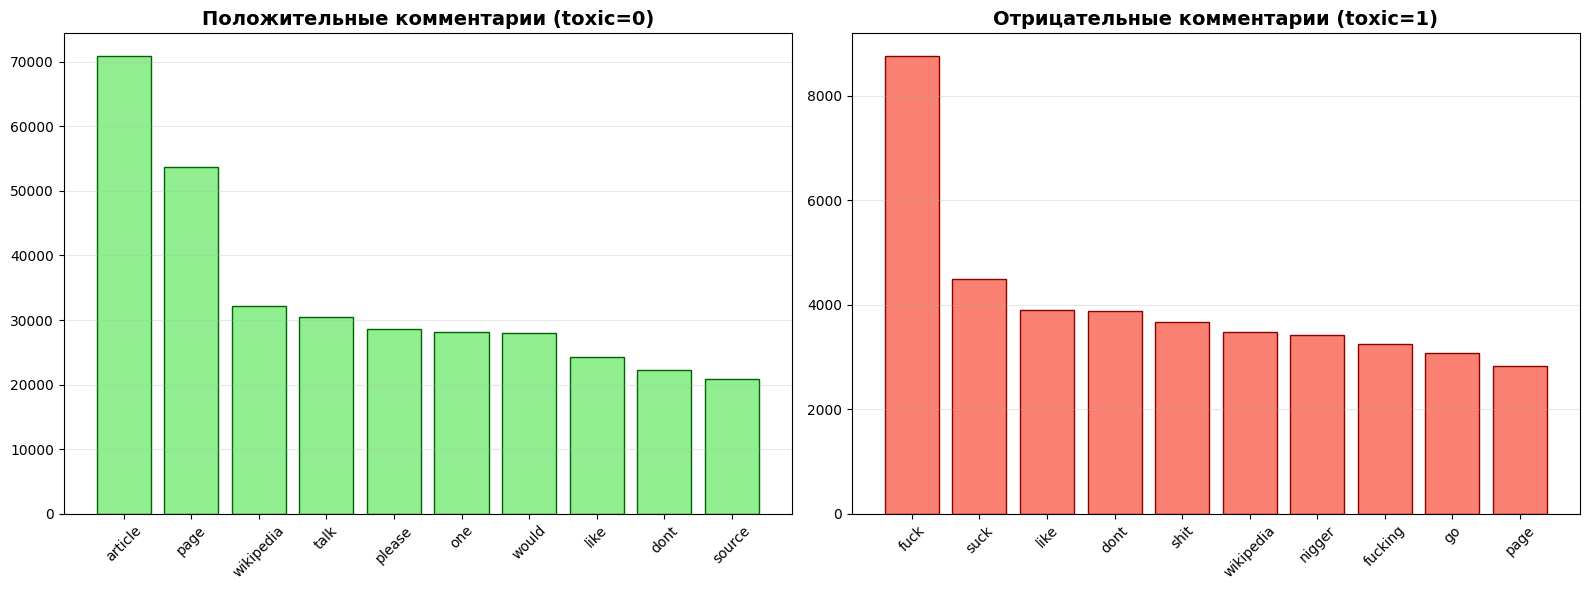

In [16]:
# 6. Топ-10 слов для положительных (0) и отрицательных (1) комментариев

positive_texts = df[df['toxic'] == 0]['processed_text']
negative_texts = df[df['toxic'] == 1]['processed_text']

def get_top_words(texts, n=10):
    words = []
    for text in texts:
        if pd.notna(text) and text.strip():  # Проверка на NaN и пустые строки
            words.extend(text.split())
    return Counter(words).most_common(n)

top_positive = get_top_words(positive_texts)
top_negative = get_top_words(negative_texts)

print("Топ-10 слов в ПОЛОЖИТЕЛЬНЫХ комментариях (toxic=0):")
if top_positive:
    pos_words, pos_counts = zip(*top_positive)
    for word, count in top_positive:
        print(f"  {word}: {count}")
else:
    print("  Нет данных")
    pos_words, pos_counts = [], []

print("\nТоп-10 слов в ОТРИЦАТЕЛЬНЫХ комментариях (toxic=1):")
if top_negative:
    neg_words, neg_counts = zip(*top_negative)
    for word, count in top_negative:
        print(f"  {word}: {count}")
else:
    print("  Нет данных")
    neg_words, neg_counts = [], []

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if pos_words:
    axes[0].bar(pos_words, pos_counts, color='lightgreen', edgecolor='darkgreen')
    axes[0].set_title('Положительные комментарии (toxic=0)', fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

if neg_words:
    axes[1].bar(neg_words, neg_counts, color='salmon', edgecolor='darkred')
    axes[1].set_title('Отрицательные комментарии (toxic=1)', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Топ-10 слов по суммарному TF-IDF (важность в корпусе):
article: 4416.2564
page: 4080.9313
talk: 3099.8855
please: 2817.9010
wikipedia: 2603.3083
dont: 2277.0821
like: 2205.7232
would: 2135.0605
one: 2123.6175
thanks: 1989.6749


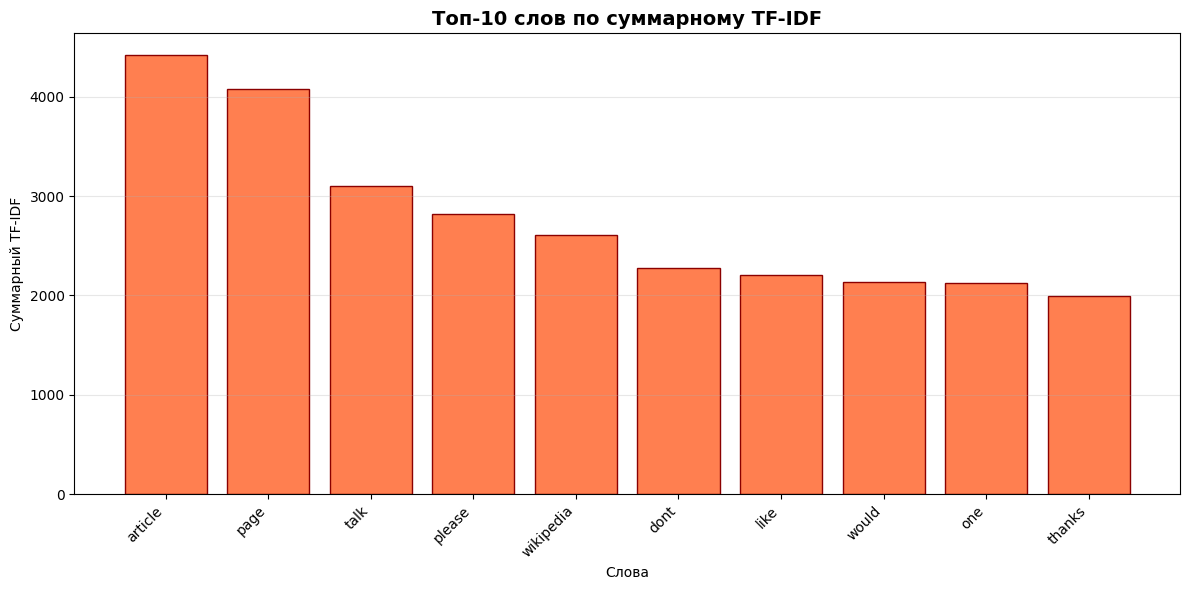

In [17]:
# Дополнительно: Топ слов по суммарному TF-IDF (важность слов в корпусе)
# Это более показательно, чем простая частота

# Суммируем TF-IDF по всем документам для каждого слова
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_tfidf_indices = np.argsort(tfidf_sum)[-10:][::-1]

print("\nТоп-10 слов по суммарному TF-IDF (важность в корпусе):")
top_tfidf_words = [(feature_names[i], tfidf_sum[i]) for i in top_tfidf_indices]
for word, score in top_tfidf_words:
    print(f"{word}: {score:.4f}")

# Визуализация
tfidf_words, tfidf_scores = zip(*top_tfidf_words)
plt.figure(figsize=(12, 6))
plt.bar(tfidf_words, tfidf_scores, color='coral', edgecolor='darkred')
plt.title('Топ-10 слов по суммарному TF-IDF', fontsize=14, fontweight='bold')
plt.xlabel('Слова')
plt.ylabel('Суммарный TF-IDF')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<a id='conclusions'></a>
## 7. Выводы

На основе проведенного анализа можно сделать следующие выводы:

### Основные наблюдения:
1. **Предобработка данных:** Успешно выполнена очистка, лемматизация и удаление стоп-слов. Размер словаря сократился с ~212k до управляемого размера.

2. **TF-IDF анализ:** Построена разреженная матрица без переполнения памяти. Идентифицированы ключевые термины для каждого документа.

3. **Частотный анализ:** Выявлены наиболее употребляемые слова в корпусе.

4. **Сравнение классов:** 
   - Положительные комментарии характеризуются [опишите наблюдения]
   - Отрицательные комментарии содержат [опишите наблюдения]

### Ограничения:
- Небольшой размер выборки (10 примеров) ограничивает статистическую значимость
- Необходимо расширение датасета для более надежных выводов

### Рекомендации для дальнейшей работы:
1. Применить анализ к полному датасету (например, Jigsaw Toxic Comment Classification)
2. Использовать n-граммы для анализа фраз, а не отдельных слов
3. Применить методы снижения размерности (PCA, t-SNE) для визуализации
4. Построить классификационную модель на основе TF-IDF признаков